In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

%matplotlib inline


In [1]:
def plot_mean_and_sdt(t,dataset):
    
    sdt_dataset = []
    mean_dataset = []
    for i in range(len(t)):
        sdt_dataset.append(np.std(dataset[:,i]))
        mean_dataset.append(np.mean(dataset[:,i]))

    Ytempmin =  np.array(mean_dataset) -np.array(sdt_dataset) 
    Ytempmax =  np.array(mean_dataset) +np.array(sdt_dataset) 
    plt.fill_between(t,Ytempmin,Ytempmax, alpha=0.3)
    plt.plot(t,np.array(mean_dataset))
    
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        
def draw_error_ellipses(gmm, ax):
    color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])
    for i, (mean, covar, color) in enumerate(zip(
            gmm.means_, gmm._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        #if not np.any(Y_ == i):
        #    continue
        #plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    

In [77]:
from pypot.primitive.move import Move

class Sanitize_records_for_gmm(object):
    """ Merge records data for gmm  
    """
    def __init__(self,dimension=0,cv_types=['spherical', 'tied', 'diag', 'full'],n_components_range=range(1, 30)):
        self.times = []
        self.dimension = dimension
        self.positions = []
        self.motors = []
        self.speeds = []
        self._X = []
        self.gmm = None
        self.__gmm_generated = False
        self.bics = []
        # For BIC optimisation
        self.cv_types = cv_types#['full']#['spherical', 'tied', 'diag', 'full']
        self.n_components_range = n_components_range
        
        
        #self.__x_updated__ = False
    def add_record(self,times,positions,speeds=None):
        # For simple tests only
        if speeds is not None:
            raise NotImplementedError
        if len(times) != len(positions):
            raise Exception("times and positions must have same dimensions")
        if self.dimension != 0:
            if len(positions[0]) != self.dimension:
                raise Exception("positions dimension exceded")
        # Dirty Sort
        X1 = [i for i in zip (times,positions)]
        X2 = [i for i in zip (self.times,self.positions)]
        X =  sorted(X1+X2)
        self.positions = []
        self.times = []
        for i in X:
            self.times.append(i[0])
            self.positions.append(i[1])
    #def _gen_X(self):
    #    self._XX = np.array([self.times,self.positions]).transpose()
    def add_move(self,move):
        move_positions = move.positions()
        
        motors = []
        times = []
        positions = []
        speeds = []

        # iterate over each record
        for key in xrange(len(move_positions)):
            motors_position = []
            motors_speed = []
            t = float(key)/move.framerate          
            for motor, values in move_positions[t].iteritems():
                if motor not in motors:
                    motors.append(motor)
                motors_position.append(values[0])
                motors_speed.append(values[1])
            times.append(t)
            positions.append(motors_position)
            speeds.append(motors_speed)
            
        # TODO: add speed 
        self.add_record(times,positions)
        self.__gmm_generated = False
        
    def to_array(self):
        t_array = np.array([self.times]).transpose()
        if self.dimension == 0:
            pos_array = np.array([self.positions]).transpose()
        else:
            pos_array = np.array(self.positions)
        self._X = np.c_[t_array,pos_array]
        return self._X
    
    def plot(self,plot_type='raw',ax=None):
        # To be rewriten
        X = self.to_array()
        if plot_type == 'raw':
            if ax is None:
                plt.scatter(X[:,0],X[:,1])
            else :
                ax.scatter(X[:,0],X[:,1])
        else:
            t = X[:,0]
            dataset=X[:,1]
            sdt_dataset = []
            mean_dataset = []
            for i in range(len(t)):
                sdt_dataset.append(np.std(dataset[:,i]))
                mean_dataset.append(np.mean(dataset[:,i]))

            Ytempmin =  np.array(mean_dataset) -np.array(sdt_dataset) 
            Ytempmax =  np.array(mean_dataset) +np.array(sdt_dataset) 
            plt.fill_between(t,Ytempmin,Ytempmax, alpha=0.3)
            plt.plot(t,np.array(mean_dataset))
    
    def gen_gmm(self):
        self.__gmm_generated = True
        X = self.to_array()
        lowest_bic = np.infty
        bic = []
        for cv_type in self.cv_types:
            for n_components in self.n_components_range:
                # Fit a mixture of Gaussians with EM
                gmm = mixture.GMM(n_components=n_components, covariance_type=cv_type)
                gmm.fit(X)
                self.bics.append(gmm.bic(X))
                if self.bics[-1] < lowest_bic:
                    lowest_bic = self.bics[-1]
                    best_gmm = gmm
        self.gmm = best_gmm
        return self.gmm

    def plot_bics(self,ax=None):
        if not self.__gmm_generated:
            self.gen_gmm()
        bic = np.array(self.bics)
        color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])
        clf = self.gmm
        bars = []

        # Plot the BIC scores
        if ax is None:
            spl = plt.subplot(2, 1, 1)
        else:
            spl = ax.subplot(2, 1, 1)

        for i, (cv_type, color) in enumerate(zip(self.cv_types, color_iter)):
            xpos = np.array(self.n_components_range) + .2 * (i - 2)
            bars.append(plt.bar(xpos, bic[i * len(self.n_components_range):
                                          (i + 1) * len(self.n_components_range)],
                                width=.2, color=color))
        plt.xticks(self.n_components_range)
        plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
        plt.title('BIC score per model')
        xpos = np.mod(bic.argmin(), len(self.n_components_range)) + .65 +\
            .2 * np.floor(bic.argmin() / len(self.n_components_range))
        plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
        spl.set_xlabel('Number of components')
        spl.legend([b[0] for b in bars], self.cv_types)
        return ax

    
    
    def plot_gmm(self,ax=None):
        if not self.__gmm_generated:
            self.gen_gmm()
        # To be improved
        color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])
        #self.gen_gmm()
        Y_ = self.gmm.predict(self._X)
        if ax is None:
            ax = plt.subplot(1,1,1)

        for i, (mean, covar, color) in enumerate(zip(
                self.gmm.means_, self.gmm._get_covars(), color_iter)):
                ## valeur propre, vecteur propre
                v, w = linalg.eigh(covar)
                u = w[0] / linalg.norm(w[0])
                # as the DP will not use every component it has access to
                # unless it needs it, we shouldn't plot the redundant
                # components.
                if not np.any(Y_ == i):
                    continue
                ax.scatter(self._X[Y_ == i, 0], self._X[Y_ == i, 1], .8, color=color)

                # Plot an ellipse to show the Gaussian component
                angle = np.arctan(u[1] / u[0])
                angle = 180 * angle / np.pi  # convert to degrees
                ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
                ell.set_clip_box(ax.bbox)
                ell.set_alpha(0.5)
                ax.add_artist(ell)
    
    
        
    
        
    
    

In [78]:
t1=[1,2,3,4]
t2=[1.1,2.1,3.5,4.5]
x1=[6,3,4.5,5]
x2=[1,4,5,2]
x11 =[[0,1],[0,2],[0,3],[1,5]]

datas = Sanitize_records_for_gmm()
datas.add_record(t1,x1)
datas.add_record(t2,x2)
datas.plot()


IndexError: too many indices

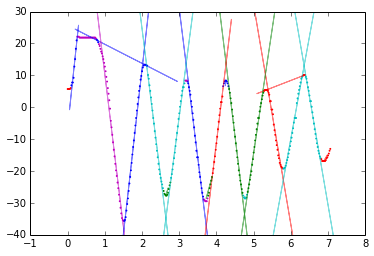

In [64]:
move_m1 = open('records/move_m1.record','r')
move_m2 = open('records/move_m2.record','r')

datas = Sanitize_records_for_gmm(1)
m1 = Move.load(move_m1)
m2 = Move.load(move_m2)
#datas.add_move(m1)
datas.add_move(m2)
datas.plot_gmm()


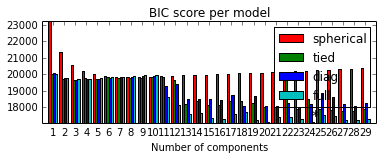

In [63]:
datas.plot_bics()


## 1 motor multiple demo of sinus

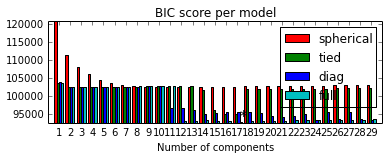

In [74]:
# number of demos
ndemo = 30

# number of periods
nperiod = np.pi

# motor specific
pmin = -60
pmax = 60

# record parameter
framerate = 10
tmin = 0
tmax = 20

# noise parameter
noise_amplitude =  0.2*(pmax-pmin) #30
noise_phase = np.pi/5#1.3
noise_time = 0.7#0.5


datas = Sanitize_records_for_gmm()


def _rand():
    return 2*(np.random.random(1)-1)

t=np.linspace(tmin,tmax,(tmax-tmin)*framerate)
y = ((pmax-pmin)/2)*np.sin(t*2*np.pi*nperiod/tmax) + (pmax+pmin)/2
datas.add_record(t,y)
mot_data = []
for i in xrange(ndemo):
    noisy_t =np.zeros(len(t))
    for n in range(len(t)):
        noisy_t[n] = t[n]+noise_time*np.random.random()
    y_noisy = (noise_amplitude*_rand())+ ((pmax-pmin)/2)*np.sin((noisy_t*2*np.pi*nperiod/tmax)+noise_phase*_rand()) + (pmax+pmin)/2
    mot_data.append(y_noisy)
    datas.add_record(noisy_t,y_noisy)


#for i in range(ndemo):
#    axes[i].plot(mot_data[i])

#datas.to_array()
datas.gen_gmm()
datas.plot_gmm()
datas.plot_bics()


#plot_mean_and_sdt(t,np.array(mot_data))


17

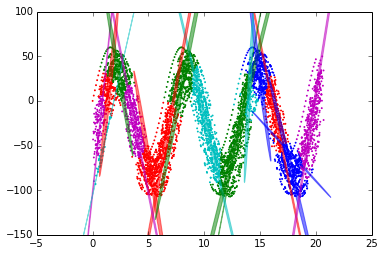

In [76]:
datas.plot_gmm()
datas.gmm.n_components

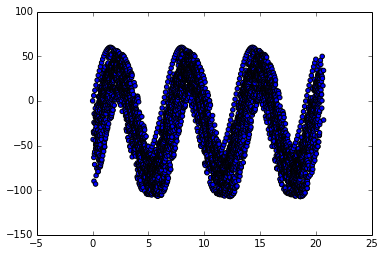

In [75]:
datas.plot()

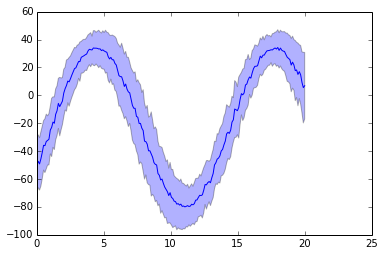

In [7]:
plot_mean_and_sdt(t,np.array(mot_data))


sklearn.mixture.gmm.GMM

In [182]:

#from sklearn.externals.six.moves import xrange

# Number of samples per component
n_samples = 70

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))

step = 4 * np.pi / n_samples

for i in xrange(X.shape[0]):
    x = i * step - 6
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3 * (np.sin(x) + np.random.normal(0, .2))



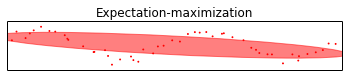

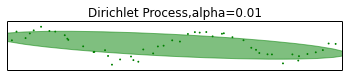

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:30: RuntimeWarning: divide by zero encountered in double_scalars


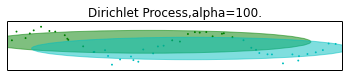

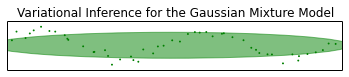

In [17]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])


for i, (clf, title) in enumerate([
        (mixture.GMM(n_components=1, covariance_type='full', n_iter=100),
         "Expectation-maximization"),
        (mixture.DPGMM(n_components=10, covariance_type='full', alpha=0.01,
                       n_iter=100),
         "Dirichlet Process,alpha=0.01"),
        (mixture.DPGMM(n_components=10, covariance_type='diag', alpha=100.,
                       n_iter=100),
         "Dirichlet Process,alpha=100."),
        (mixture.VBGMM(n_components=1, covariance_type='diag',n_iter=100),
         "Variational Inference for the Gaussian Mixture Model")]):
    
    clf.fit(X)
    splot = plt.subplot(4, 1, 1 + i)
    Y_ = clf.predict(X)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)


    plt.xlim(-6, 4 * np.pi - 6)
    plt.ylim(-5, 5)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    
    plt.show()

([], <a list of 0 Text yticklabel objects>)

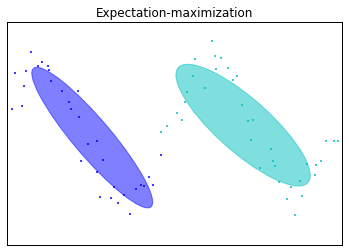

In [186]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

title = 'Expectation-maximization'
clf = mixture.VBGMM(n_components=4, covariance_type='full', n_iter=100)
clf.fit(X)
Y_ = clf.predict(X)
splot = plt.subplot(1,1,1)

for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        ## valeur propre, vecteur propre
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

plt.xlim(-6, 4 * np.pi - 6)
plt.ylim(-5, 5)
plt.title(title)
plt.xticks(())
plt.yticks(())
 



In [24]:
Y_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])